Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

# References
- [Outils pour le Big Data - Pierre Nerzic 🇫🇷](https://perso.univ-rennes1.fr/pierre.nerzic/Hadoop/)
- [Writing an Hadoop MapReduce Program in Python - Michael G. Noll](http://www.michael-noll.com/tutorials/writing-an-hadoop-mapreduce-program-in-python/)
- [Hadoop MapReduce Framework Tutorials with Examples - Matthew Rathbone](https://blog.matthewrathbone.com/2013/01/05/a-quick-guide-to-hadoop-map-reduce-frameworks.html)
- [Python course: Lambda, filter, reduce and map](http://www.python-course.eu/lambda.php)
- [Mastering Python for Data Science - Samir Madhavan](https://www.packtpub.com/big-data-and-business-intelligence/mastering-python-data-science)
* [Implementing MapReduce with multiprocessing](https://pymotw.com/2/multiprocessing/mapreduce.html)
* [MPI4PY examples](https://github.com/jbornschein/mpi4py-examples)
* [sharedmem package](http://rainwoodman.github.io/sharedmem/)
- [A Guide to Python Frameworks for Hadoop](http://blog.cloudera.com/blog/2013/01/a-guide-to-python-frameworks-for-hadoop/)

# Data processing through MapReduce

![MapReduce](http://mm-tom.s3.amazonaws.com/blog/MapReduce.png)

# Python Map Reduce

## Exercise 1
Compute a vector norm $|v| = \sqrt(\sum_i v_i^2)$ with this process:
- use `map` function
- use `reduce` funtion from `functools`

In [42]:
V = [4,1,2,3]

<button data-toggle="collapse" data-target="#sol1" class='btn btn-primary'>Solution</button>
<div id="sol1" class="collapse">
```python
from operator import add
from functools import reduce
from math import sqrt

f = lambda x: x*x   # Function applied
L = map(f, V)       # map return a iterator
s = reduce(add,L)   # reduce compute the sum
sqrt(s) == sqrt(sum(map(f,V)))
```

- The `map(func, seq)` Python function applies the function func to all the elements of the sequence seq. It returns a new list with the elements changed by func

- The function `reduce(func, seq)` continually applies the function func() to the sequence seq and return a single value. For example, reduce(f, [1, 2, 3, 4, 5]) calculates f(f(f(f(1,2),3),4),5).

# Wordcount Example

[WordCount](https://hadoop.apache.org/docs/current/hadoop-mapreduce-client/hadoop-mapreduce-client-core/MapReduceTutorial.html#Example:_WordCount_v1.0) is a simple application that counts the number of occurrences of each word in a given input set.

Each mapper takes a line of text files as input and breaks it into words. It then emits a key/value pair of the word and 1 (separated by a tab). Each reducer sums the counts for each word and emits a single key/value with the word and sum.

In [43]:
%mkdir -p hadoop

In [44]:
from lorem import text
t = text()

with open("hadoop/sample.txt", "w") as sample:
    sample.write(t)

print(t[:500]) # print only 500 first characters

Etincidunt etincidunt sit dolor aliquam velit. Ut ut modi quiquia velit. Labore magnam amet aliquam voluptatem quisquam aliquam. Quisquam velit dolorem tempora eius. Ipsum magnam tempora ipsum consectetur. Quisquam consectetur tempora labore numquam porro aliquam. Labore ut velit ut quisquam est quiquia. Etincidunt est ut sit voluptatem etincidunt labore amet. Adipisci amet adipisci non sit. Sed sit dolorem sit adipisci est.

Quisquam est dolore aliquam. Aliquam sit dolor ipsum labore. Non quaer


## Exercise 2

Write a python program that counts the number of words in that file.


<button data-toggle="collapse" data-target="#sol2" class='btn btn-primary'>Solution</button>
<div id="sol2" class="collapse">
```python
import re
splitter = re.compile('\w+')
with open('hadoop/sample.txt', 'r') as f:
    data = f.read()
result = len(splitter.findall(data))
result
```

### Wordcount using a collections.Counter

In [45]:
from collections import Counter
from string import punctuation

with open("hadoop/sample.txt", "r") as sample:
    translator = str.maketrans('', '', punctuation)
    p = sample.read().lower().translate(translator).replace('\n',' ').split(' ')
    c = Counter(p)
    del c['']
    print(sorted(c.most_common()))

[('adipisci', 9), ('aliquam', 17), ('amet', 11), ('consectetur', 10), ('dolor', 12), ('dolore', 4), ('dolorem', 9), ('eius', 13), ('est', 8), ('etincidunt', 12), ('ipsum', 11), ('labore', 10), ('magnam', 12), ('modi', 4), ('neque', 10), ('non', 13), ('numquam', 2), ('porro', 8), ('quaerat', 11), ('quiquia', 12), ('quisquam', 13), ('sed', 9), ('sit', 13), ('tempora', 14), ('ut', 16), ('velit', 9), ('voluptatem', 15)]


### Wordcount using a collections.defaultdict

In [46]:
from collections import defaultdict
from string import punctuation

with open("hadoop/sample.txt", "r") as sample:
    translator = str.maketrans('', '', punctuation)
    t = sample.read().lower().translate(translator).replace('\n',' ').split(' ')
    d = defaultdict(int)
    for k in t:
        d[k] += 1

    del d[''] # remove empty string from the list
    print(sorted(d.items()))
    

[('adipisci', 9), ('aliquam', 17), ('amet', 11), ('consectetur', 10), ('dolor', 12), ('dolore', 4), ('dolorem', 9), ('eius', 13), ('est', 8), ('etincidunt', 12), ('ipsum', 11), ('labore', 10), ('magnam', 12), ('modi', 4), ('neque', 10), ('non', 13), ('numquam', 2), ('porro', 8), ('quaerat', 11), ('quiquia', 12), ('quisquam', 13), ('sed', 9), ('sit', 13), ('tempora', 14), ('ut', 16), ('velit', 9), ('voluptatem', 15)]


## Map-Reduce

### Exercise 3: Read file and return a key/value pairs

Write a Python function with file name as input that returns a sorted sequence of (word, 1) values.

<button data-toggle="collapse" data-target="#words" class='btn btn-primary'>Solution</button>
<div id="words" class="collapse">
```python
import string

def words(file):
    """
    Read a text file and return a sorted list of (word, 1) values.
    """
    translator = str.maketrans('', '', string.punctuation)
    output = []
    with open(file) as f:
        for line in f:
            line = line.strip()
            line = line.translate(translator)
            for word in line.split():
                word = word.lower()
                output.append((word, 1))
    output.sort()
    return output
```

In [48]:
import string

def words(file):
    """
    Read a text file and return a sorted list of (word, 1) values.
    """
    translator = str.maketrans('', '', string.punctuation)
    output = []
    with open(file) as f:
        for line in f:
            line = line.strip()
            line = line.translate(translator)
            for word in line.split():
                word = word.lower()
                output.append((word, 1))
    output.sort()
    return output
words('hadoop/sample.txt')[::10]

[('adipisci', 1),
 ('aliquam', 1),
 ('aliquam', 1),
 ('amet', 1),
 ('consectetur', 1),
 ('dolor', 1),
 ('dolore', 1),
 ('dolorem', 1),
 ('eius', 1),
 ('est', 1),
 ('etincidunt', 1),
 ('ipsum', 1),
 ('labore', 1),
 ('magnam', 1),
 ('modi', 1),
 ('neque', 1),
 ('non', 1),
 ('porro', 1),
 ('quaerat', 1),
 ('quiquia', 1),
 ('quisquam', 1),
 ('quisquam', 1),
 ('sit', 1),
 ('sit', 1),
 ('tempora', 1),
 ('ut', 1),
 ('ut', 1),
 ('velit', 1),
 ('voluptatem', 1)]

# Reduce 

Write the funtion to read the results of words and sum the occurrences of each word to a final count, and then output the results
as a list of (word, occurences). Two steps:
- Group (word, 1) pairs into a dictionary as
```python
{word1 : [1, 1], word2 : [1, 1, 1], word3 : [1] }
```
- Reduce operation prints out the word and its number of occurences.

<button data-toggle="collapse" data-target="#reduce" class='btn btn-primary'>Solution</button>
<div id="reduce" class="collapse">
```python
def reduce(words):
    """ Read the sorted list from map and print out every word with 
    its number of occurences"""
    d = {}
    for w in words:
        try:
            d[w[0]] +=1
        except KeyError:
            d[w[0]] = 1
    return d
```

In [49]:
def reduce(words):
    """ Read the sorted list from map and print out every word with 
    its number of occurences"""
    d = {}
    for w in words:
        try:
            d[w[0]] +=1
        except KeyError:
            d[w[0]] = 1
    return d

In [50]:
import operator
res = reduce(words('hadoop/sample.txt'))
res = sorted(res.items(), key=operator.itemgetter(1))
res.reverse()
res[:10]

[('aliquam', 17),
 ('ut', 16),
 ('voluptatem', 15),
 ('tempora', 14),
 ('sit', 13),
 ('quisquam', 13),
 ('non', 13),
 ('eius', 13),
 ('quiquia', 12),
 ('magnam', 12)]

- This  approach load all the data into memory. A very large file might fill up memory. 
- Counting words in each line is totally independent of the others. 
- We can evaluate each piece of data and immediately free up the memory space. 
- Data chunks would be small enough not to stress memory, but big enough for efficient use of the CPU.

# Multiprocessing version

The multiprocessing Pool class provides a map function. Partition and distribute input to a user-specified function in pool of worker processes is automatic.

## Example


In [51]:
from multiprocessing import Pool
from lorem import paragraph

words = paragraph().split() # Create a list of words
if __name__ == '__main__': # Executed only on main process.
    with Pool(4) as p:
        print(p.map(len, words)) # Print words length
    

[3, 10, 7, 5, 6, 10, 7, 5, 3, 7, 3, 4, 7, 4, 8, 10, 5, 5, 6, 4, 7, 11, 5, 7, 7, 7, 7, 8, 4, 6, 5, 5, 3, 5, 8, 4, 4, 3, 5, 7, 4, 7, 7, 5, 7, 4, 4, 7, 8, 6, 3, 8, 4, 3, 7, 2, 4, 6]


- Pool() launches one slave process per physical processor on the computer. 
- pool.map(...) divides the input list into chunks and puts the tasks (function + chunk) on a queue.
- Each slave process takes a task (function + a chunk of data), runs map(function, chunk), and puts the result on a result list.
- pool.map on the master process waits until all tasks are handled and returns the concatenation of the result lists.

# Map

Same function words

In [52]:
import string
import multiprocessing as mp
def words_mp(file):
    """
    Read a text file and return a sorted list of (word, 1) values.
    """
    print(mp.current_process().name, 'reading', file)
    translator = str.maketrans('', '', string.punctuation)
    output = []
    try:
        with open(file) as f:
            for line in f:   
                line = line.strip()
                line = line.translate(translator)
                for word in line.split():
                    if word.isalpha():
                        word = word.lower()
                        output.append((word, 1))
                        
    except UnicodeDecodeError as err:
        print("Some error occurred decoding file %s: %s" % (file, err))
                
    output.sort()
    return output

## Partition

Before **reduce** operation, data must be aligned in a container. Create a function named `partition` that stores the key/value pairs from `words` into a [defaultdict](https://docs.python.org/3.6/library/collections.html#collections.defaultdict) from `collections` module. Ouput will be:
```python
[('word1', [1, 1]), ('word2', [1]), ('word3', [1, 1, 1])]
```

In [53]:
import collections
def partition_mp(mapped_values):
    """
        Organize the mapped values by their key.
        Returns an unsorted sequence of tuples 
        with a key and a sequence of values.
    """
    partitioned_data = collections.defaultdict(list)
    for key, value in mapped_values:
        partitioned_data[key].append(value)
    return partitioned_data.items()

## Reduce

In [54]:
def reduce_mp(item):
    """Convert the partitioned data for a word to a
    tuple containing the word and the number of occurances.
    """
    word, occurances = item
    return (word, len(occurances))

In [55]:
mapped_values = words_mp('hadoop/sample.txt')
print(mapped_values)

MainProcess reading hadoop/sample.txt
[('adipisci', 1), ('adipisci', 1), ('adipisci', 1), ('adipisci', 1), ('adipisci', 1), ('adipisci', 1), ('adipisci', 1), ('adipisci', 1), ('adipisci', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('aliquam', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('amet', 1), ('consectetur', 1), ('consectetur', 1), ('consectetur', 1), ('consectetur', 1), ('consectetur', 1), ('consectetur', 1), ('consectetur', 1), ('consectetur', 1), ('consectetur', 1), ('consectetur', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolor', 1), ('dolore', 1), ('dolore',

In [56]:
partioned_values = partition_mp(mapped_values)
print(partioned_values)

dict_items([('adipisci', [1, 1, 1, 1, 1, 1, 1, 1, 1]), ('aliquam', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('amet', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('consectetur', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('dolor', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('dolore', [1, 1, 1, 1]), ('dolorem', [1, 1, 1, 1, 1, 1, 1, 1, 1]), ('eius', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('est', [1, 1, 1, 1, 1, 1, 1, 1]), ('etincidunt', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('ipsum', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('labore', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('magnam', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('modi', [1, 1, 1, 1]), ('neque', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('non', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('numquam', [1, 1]), ('porro', [1, 1, 1, 1, 1, 1, 1, 1]), ('quaerat', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('quiquia', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('quisquam', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), ('sed', [1, 1, 1, 1, 1, 1, 1, 1, 1]), ('sit', [1, 1, 1, 1, 

In [57]:
import glob, itertools, operator
from multiprocessing import Pool
files = glob.glob('hadoop/*.txt')

if __name__ == '__main__':
    with Pool(processes=6) as p:
        mapped_values = p.map(words_mp,files)
        partitioned_data = partition_mp(itertools.chain(*mapped_values))
        reduced_values = p.map(reduce_mp, partitioned_data)
        reduced_values.sort(key=operator.itemgetter(1)) # sort values by number of occurences
        reduced_values.reverse() # Put highest number of occurences on top
        
reduced_values[:10]

ForkPoolWorker-11 reading hadoop/sample.txt


[('aliquam', 17),
 ('ut', 16),
 ('voluptatem', 15),
 ('tempora', 14),
 ('sit', 13),
 ('quisquam', 13),
 ('non', 13),
 ('eius', 13),
 ('quiquia', 12),
 ('magnam', 12)]

- [itertools.chain(*mapped_values)](https://docs.python.org/3.6/library/itertools.html#itertools.chain) is used for treating consecutive sequences as a single sequence. It makes an iterator that returns elements from the first iterable until it is exhausted, then proceeds to the next iterable, until all of the iterables are exhausted.
- [operator](https://docs.python.org/3/library/operator.html).itemgetter(1)
Return a callable object that fetches item from its operand using the operand’s __getitem__() method. 
```python
inventory = [('apple', 3), ('banana', 2), ('pear', 5), ('orange', 1)]
getcount = itemgetter(1)
>>> list(map(getcount, inventory))
[3, 2, 5, 1]
>>> sorted(inventory, key=getcount)
[('orange', 1), ('banana', 2), ('apple', 3), ('pear', 5)]
```

# sharedmem

- http://github.com/rainwoodman/sharedmem
- https://pypi.python.org/pypi/sharedmem

Create a list of sample texts in different files


In [58]:
from lorem import text

for i in range(10):
    with open("hadoop/sample_{0:1d}.txt".format(i), "w") as sample:
        sample.write(text())

In [59]:
import sharedmem
import glob
samples = glob.glob('hadoop/sample_*.txt')

word_count = {
        'dolorem': 0,
        'ipsum': 0,
            }

with sharedmem.MapReduce() as pool:

    def work(file):
        print(file)
        with open(file) as f:
            for line in f:
                my_word_count = dict([(word, 0) for word in word_count])
                for word in line.replace('.', ' ').split():
                    if word in word_count:
                        my_word_count[word] += 1

        return my_word_count

    def reduce(her_word_count):
        for word in word_count:
            word_count[word] += her_word_count[word]

    pool.map(work, samples, reduce=reduce)

word_count # count of 'dolorem' and 'ipsum'

hadoop/sample_0.txt
hadoop/sample_1.txt
hadoop/sample_2.txt
hadoop/sample_3.txt
hadoop/sample_4.txt
hadoop/sample_6.txt
hadoop/sample_8.txt
hadoop/sample_5.txt
hadoop/sample_7.txt
hadoop/sample_9.txt


{'dolorem': 19, 'ipsum': 16}

#  Dask Bag

In [60]:
import os
import dask.bag as db

lines = db.read_text(os.path.join('hadoop', 'sample_*.txt'))
lines

dask.bag<bag-fro..., npartitions=10>

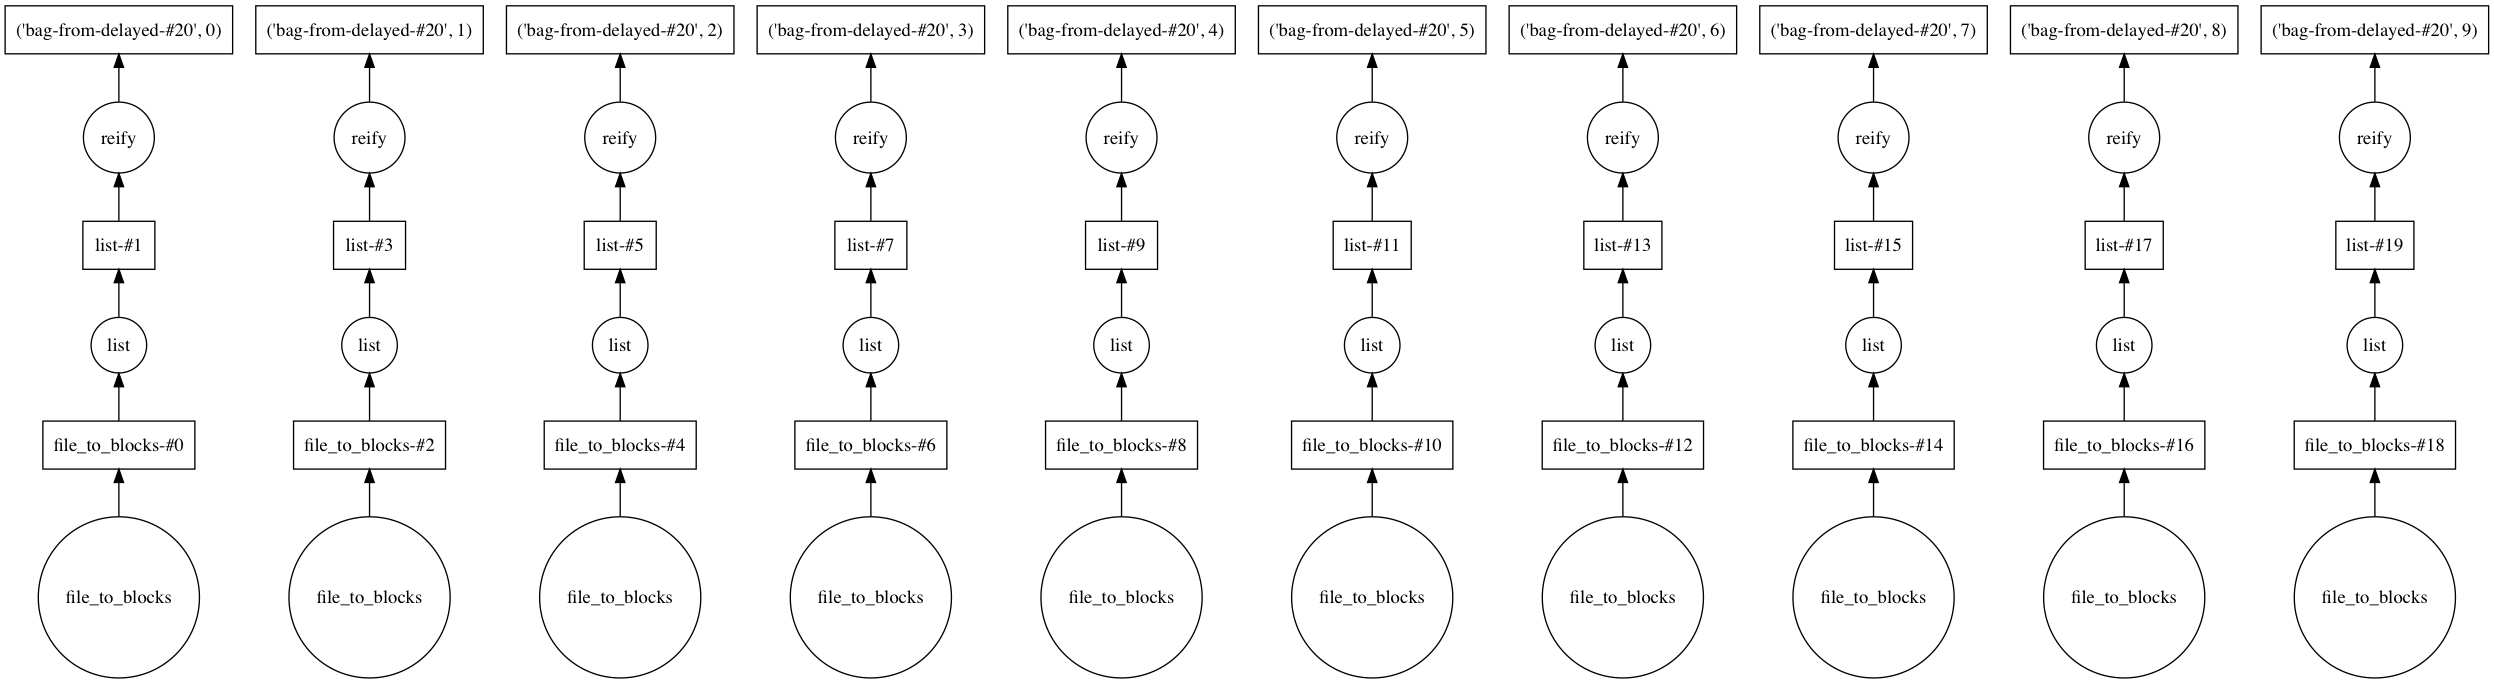

In [61]:
lines.visualize()

In [62]:
lines.take(1) # Look at the first element

('Neque velit dolorem porro. Eius dolorem eius consectetur eius voluptatem consectetur. Dolorem ut sit eius ipsum labore sit. Ipsum adipisci quisquam quiquia labore adipisci dolorem. Aliquam aliquam dolorem etincidunt voluptatem dolore velit. Sed amet numquam ut. Velit porro tempora amet dolor tempora dolore. Dolorem neque dolore amet.\n',)

Bag method can split the lines into words, concatenate the nested lists of words into a single list, count the frequencies of each word, then list the top 10 words by their count:

In [63]:
wordcount = lines.str.split().flatten().frequencies().topk(10, lambda x: x[1])

In [64]:
wordcount.compute()

[('tempora', 66),
 ('aliquam', 65),
 ('dolor', 60),
 ('dolore', 59),
 ('velit', 58),
 ('adipisci', 58),
 ('magnam', 58),
 ('eius', 57),
 ('sit', 57),
 ('est', 57)]



# Deploying the MapReduce code on Hadoop

This Python must use the [Hadoop Streaming API](http://hadoop.apache.org/docs/stable/hadoop-streaming/HadoopStreaming.html) to pass data between our Map and Reduce code via Python’s sys.stdin (standard input) and sys.stdout (standard output). 

Download some books
* [The Outline of Science, Vol. 1 (of 4) by J. Arthur Thomson](http://www.gutenberg.org/ebooks/20417.txt.utf-8)
* [Ulysses by James Joyce](http://www.gutenberg.org/files/4300/4300-0.txt)
* [The Art of War by 6th cent. B.C. Sunzi](http://www.gutenberg.org/ebooks/132.txt.utf-8)
* [The Adventures of Sherlock Holmes by Sir Arthur Conan Doyle](http://www.gutenberg.org/ebooks/1661.txt.utf-8)
* [The Devil’s Dictionary by Ambrose Bierce](http://www.gutenberg.org/ebooks/972.txt.utf-8)
* [Encyclopaedia Britannica, 11th Edition, Volume 4, Part 3](http://www.gutenberg.org/ebooks/19699.txt.utf-8)



# Map 

The following Python code read data from sys.stdin, split it into words and output a list of lines mapping words to their (intermediate) counts to sys.stdout. For every word it outputs <word> 1 tuples immediately. 


In [65]:
%%file hadoop/mapper.py
#!/usr/bin/env python
from __future__ import print_function
import sys, string

# input comes from standard input
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # strip punctuation
    line = line.translate(None,string.punctuation)    

    # split the line into words
    words = line.split()
    # increase counters
    for word in words:
        # write the results to standard output;
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1
        print ('%s\t%s' % (word, 1))

Writing hadoop/mapper.py


In [66]:
!chmod +x hadoop/mapper.py 

# Reduce 

The following code reads the results of mapper.py and sum the occurrences of each word to a final count, and then output its results to sys.stdout.
Remember that Hadoop sorts map output so it is easier to count words.


In [67]:
%%file hadoop/reducer.py
#!/usr/bin/env python
from __future__ import print_function
from operator import itemgetter
import sys


current_word = None
current_count = 0
word = None

# input lines
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    
    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to sys.stdout
            print ('{}\t{}'.format(current_word, current_count))
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print ('{}\t{}'.format(current_word, current_count))

Writing hadoop/reducer.py


In [68]:
!chmod +x hadoop/reducer.py

# Test

In [69]:
!cat hadoop/sample.txt | ./hadoop/mapper.py | sort | ./hadoop/reducer.py

Adipisci	2
Aliquam	5
Amet	4
Consectetur	1
Dolor	2
Dolorem	1
Eius	2
Etincidunt	5
Ipsum	1
Labore	2
Neque	1
Non	3
Porro	1
Quaerat	2
Quiquia	3
Quisquam	5
Sed	1
Ut	3
Velit	3
Voluptatem	3
adipisci	7
aliquam	12
amet	7
consectetur	9
dolor	10
dolore	4
dolorem	8
eius	11
est	8
etincidunt	7
ipsum	10
labore	8
magnam	12
modi	4
neque	9
non	10
numquam	2
porro	7
quaerat	9
quiquia	9
quisquam	8
sed	8
sit	13
tempora	14
ut	13
velit	6
voluptatem	12


## Execution on Hadoop cluster

* Copy books to HDFS
* Run the WordCount MapReduce

Makefile

In [75]:
%%file hadoop/Makefile
HADOOP_TOOLS=/usr/local/Cellar/hadoop/2.8.1/libexec/share/hadoop/tools/lib/
HDFS_DIR=/user/${USER}

BOOKS = books/20417.txt \
books/4300-0.txt books/132.txt books/1661.txt books/972.txt books/19699.txt 

download:
	mkdir -p books
	wget -q -O books/20417.txt http://www.gutenberg.org/ebooks/20417.txt.utf-8
	wget -q -O books/4300-0.txt http://www.gutenberg.org/files/4300/4300-0.txt
	wget -q -O books/132.txt http://www.gutenberg.org/ebooks/132.txt.utf-8
	wget -q -O books/1661.txt http://www.gutenberg.org/ebooks/1661.txt.utf-8
	wget -q -O books/972.txt http://www.gutenberg.org/ebooks/972.txt.utf-8
	wget -q -O books/19699.txt http://www.gutenberg.org/ebooks/19699.txt.utf-8

copy_to_hdfs: ${BOOKS}
	hdfs dfs -put books books
	
run_with_hadoop: 
	hadoop jar ${HADOOP_TOOLS}/hadoop-streaming-2.8.1.jar \
    -file  ${PWD}/mapper.py  -mapper  ${PWD}/mapper.py \
    -file  ${PWD}/reducer.py -reducer ${PWD}/reducer.py \
    -input ${HDFS_DIR}/books/* -output ${HDFS_DIR}/output-hadoop

run_with_yarn: 
	yarn jar ${HADOOP_TOOLS}/hadoop-streaming-2.8.1.jar \
	-file  ${PWD}/mapper.py  -mapper  ${PWD}/mapper.py \
	-file  ${PWD}/reducer.py -reducer ${PWD}/reducer.py \
	-input ${HDFS_DIR}/books/* -output ${HDFS_DIR}/output-yarn


Overwriting hadoop/Makefile


### Run

```bash
make downloads
make copy_to_hdfs
make run_with_hadoop
make run_with_yarn
```


# Dask Cluster computation with HDFS
http://dask.pydata.org/en/latest/examples/bag-word-count-hdfs.html

```shell
$ dask-scheduler  # On the head node
$ dask-worker SCHEDULER_IP:SCHEDULER_PORT --nprocs 4 --nthreads 1  # On the compute nodes
```

# Map Reduce with mrjob

https://mrjob.readthedocs.io

- `mrjob` is an open-source Python framework that wraps Hadoop Streaming. 
- `mrjob` allows the user to work with any objects as keys and mappers. 
- `mrjob` appears to be the most actively developed.
- A job is defined by a class that inherits from MRJob and contains methods that define the *steps*.
- A *step* consists of a mapper, a combiner, and a reducer. All of those are optional, though you must have at least one.

In [37]:
%%file mr_word_count.py

from mrjob.job import MRJob


class MRWordFrequencyCount(MRJob):

    def mapper(self, _, line):
        yield "chars", len(line)
        yield "words", len(line.split())
        yield "lines", 1

    def reducer(self, key, values):
        yield key, sum(values)


if __name__ == '__main__':
    MRWordFrequencyCount.run()

Overwriting mr_word_count.py


In [38]:
%run mr_word_count.py hadoop/sample.txt

No configs found; falling back on auto-configuration
Creating temp directory /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_word_count.navaro.20170925.203702.609185
Running step 1 of 1...
Streaming final output from /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_word_count.navaro.20170925.203702.609185/output...


"chars"	1496
"lines"	9
"words"	211


Removing temp directory /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_word_count.navaro.20170925.203702.609185...


### Job that finds the most commonly used word in the input

In [39]:
%%file mr_most_used_word.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re

WORD_RE = re.compile(r"[\w']+")

class MRMostUsedWord(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reducer_count_words),
            MRStep(reducer=self.reducer_find_max_word)
        ]

    def mapper_get_words(self, _, line):
        # yield each word in the line
        for word in WORD_RE.findall(line):
            yield (word.lower(), 1)

    def combiner_count_words(self, word, counts):
        # optimization: sum the words we've seen so far
        yield (word, sum(counts))

    def reducer_count_words(self, word, counts):
        # send all (num_occurrences, word) pairs to the same reducer.
        # num_occurrences is so we can easily use Python's max() function.
        yield None, (sum(counts), word)

    # discard the key; it is just None
    def reducer_find_max_word(self, _, word_count_pairs):
        # each item of word_count_pairs is (count, word),
        # so yielding one results in key=counts, value=word
        yield max(word_count_pairs)


if __name__ == '__main__':
    MRMostUsedWord.run()


Writing mr_most_used_word.py


In [40]:
%run mr_most_used_word.py hadoop/sample.txt

No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
Creating temp directory /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_most_used_word.navaro.20170925.203732.925762
Creating temp directory /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_most_used_word.navaro.20170925.203732.925762
Running step 1 of 2...
Running step 1 of 2...
Running step 2 of 2...
Running step 2 of 2...
Streaming final output from /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_most_used_word.navaro.20170925.203732.925762/output...
Streaming final output from /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_most_used_word.navaro.20170925.203732.925762/output...


14	"porro"


Removing temp directory /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_most_used_word.navaro.20170925.203732.925762...
Removing temp directory /var/folders/56/lhgl67bx4qj6tvjx41b1wgdr0000gn/T/mr_most_used_word.navaro.20170925.203732.925762...


In [41]:
#%%file spark_wordcount.py

import findspark
findspark.init()

import sys
from operator import add

from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName("PythonWordCount")\
        .getOrCreate()

file = "hadoop/sample.txt"

lines = spark.read.text(file).rdd.map(lambda r: r[0])
counts = lines.flatMap(lambda x: x.split(' ')) \
                  .map(lambda x: (x, 1)) \
                  .reduceByKey(add)
output = counts.collect()
for (word, count) in output:
    print("%s: %i" % (word, count))

spark.stop()

AnalysisException: 'Path does not exist: hdfs://localhost:9000/user/navaro/hadoop/sample.txt;'